In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist
import networkx as nx
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False  


import os
import re
import math

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR,LinearSVR
from sklearn.ensemble import AdaBoostRegressor,ExtraTreesRegressor,RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor


from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict # 交叉验证所需的函数
from sklearn.model_selection import KFold,LeaveOneOut,LeavePOut,ShuffleSplit # 交叉验证所需的子集划分方法
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit # 分层分割
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut,LeavePGroupsOut,GroupShuffleSplit # 分组分割



from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,mean_squared_error,mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# path = "../A2_data/A1_rawdata/Au20_OPT_1000/"
path = "../A2_data/A1_rawdata/B45-_OPT_3751/"

# 读取文件名
def get_allfile(path):
    filelist = []
    get_dir = os.listdir(path)
    for i in get_dir:
        filelist.append(os.path.join(path,i))
    
    return filelist

# 测试
filelist = get_allfile(path)
# filelist

In [3]:

# 读取团簇数据
def read_one_xyz(filename):
    xyz = []
    with open(filename, 'r') as f: # 读取每一行
        flines = f.readlines()
        for fl in range(len(flines)):
            if fl == 0: # 第一行为原子个数
                num = flines[fl]
            elif fl == 1: # 第二行为能量
                power = np.array(re.findall(r"[-]?\d+\.?\d*",str(flines[fl]))[-1]).astype(float)
            else: # 其余行为坐标点
                xyz.append(flines[fl].split())
                
    axis_xyz = []  
    for i in xyz[1:]: # 划分坐标点为 x,y,z
        axis_xyz.append(i[1:4])
    axis_xyz_num = np.array(axis_xyz).astype(float)
    
    return axis_xyz_num,power

# 测试
# xyz,power = read_one_xyz("../A2_data/A1_rawdata/Au20_OPT_1000/2.xyz")
xyz,power = read_one_xyz("../A2_data/A1_rawdata/B45-_OPT_3751/2.xyz")
power
# xyz

array(-113674.6411145)

In [4]:
# 生成衍生变量

def distmatrix(xyz_matrix):
    """计算原子距离矩阵"""
    dist=cdist(xyz_matrix,xyz_matrix,metric='euclidean')
    return dist
dist = distmatrix(xyz) # 测试


def dict_index(distmatrix):
    """
    距离矩阵相关指标：最大距离，最小距离，平均距离，平均距离，中位数距离
    """
    temp = []
    
    for i in range(distmatrix.shape[0]): # 遍历距离矩阵所有行
        
        for j in range(distmatrix.shape[1]): # 遍历距离矩阵所有列
            if j >= i: # 不考虑原子与自身的距离
                continue
            temp.append(distmatrix[i,j]) # 将每个距离添加到列表，便于计算统计指标
    mindist = min(temp)
    maxdist = max(temp)
    meandist = np.mean(temp)
    meddist = np.median(temp)
    sumdist = sum(temp)
    return mindist,maxdist,meandist,meddist,sumdist
mindist,maxdist,meandist,meddist,sumdist = dict_index(dist) # 测试


def close_matrix(dist,index):
    """
    根据距离矩阵得到邻接矩阵
    """
    matrix = np.where(dist>index,1,0)    # 根据距离与index的相对来判断是否原子之间有边
    return matrix


def netgraph_index(matrix):
    """
    网络图结构指标分析
    """
    G = nx.Graph(matrix)  # 根据邻接矩阵构建网络结构
    
    Gnum =  G.number_of_edges()   # 网络边的数量
    mean_cluster = nx.average_clustering(G) # 平均聚类系数
    netrans = nx.transitivity(G) # 网络传递性
    mean_degrcenter = np.average(list(nx.degree_centrality(G).values())) # 平均度中心性
    mean_closcenter = np.average(list(nx.closeness_centrality(G).values())) # 平均接近中心性
    mean_betwcenter = np.average(list(nx.betweenness_centrality(G).values())) # 平均中介中心性
    
    return Gnum,mean_cluster,netrans,mean_degrcenter,mean_closcenter,mean_betwcenter


def f_c(r_ij,r_cut=6):
    """分子性质衍生特征的切断函数f_c"""
    if r_cut > r_ij:  # r_ij:原子之间的距离(or距离矩阵？)
        f = (np.cos(np.pi*r_ij/r_cut)+1)/2
    else:
        f = 0
    return f


def G_func(xyz,yita=1,r_s=3):
    """G1,G2函数（改写为了所有原子的和、均值）"""
    g1_temp,g2_temp = [],[]
    for j in range(xyz.shape[0]):
        f_c_ls1 = []
        f_c_ls2 = []
        for k in range(xyz.shape[0]):
            if k == j:
                continue
            dist_vec = np.linalg.norm(np.asarray(xyz[j]) - np.asarray(xyz[k]))
            exp_dist_vec = np.exp(-yita * (dist_vec - r_s)**2)
            f_c_ls1.append(f_c(dist_vec))
            f_c_ls2.append(exp_dist_vec * f_c(dist_vec))
        g1_temp.append(sum(f_c_ls1))  # 文献中给出的G1,每个团簇有n个G1
        g2_temp.append(sum(f_c_ls2))  # 文献中给出的G2,每个团簇有n个G2
        
    g1_sum = np.sum(g1_temp)  # 对每个团簇的G1求和
    g2_sum = np.sum(g2_temp)  # 对每个团簇的G2求和
    g1 = np.average(g1_temp)  # 对每个团簇的G1求平均
    g2 = np.average(g2_temp)  # 对每个团簇的G2求平均
    return g1_sum,g2_sum,g1,g2,g1_temp,g2_temp
g1_sum,g2_sum,g1,g2,g1_temp,g2_temp = G_func(xyz) # 测试


def get_coulombMatrix(mole,zi,eigpercent=1):
    """
    计算库伦矩阵特征值,每个团簇的库伦矩阵的特征值大小排序
    """
    cij = np.zeros((mole.shape[0],mole.shape[0]))  # 初始化库伦矩阵
    for i in range(mole.shape[0]): # 遍历所有原子
        for j in range(mole.shape[0]): # 计算库伦矩阵
            if i == j:
                cij[i][j] = 0.5 * zi ** 2.4
            else:
                cij[i][j] = zi * zi / (np.linalg.norm((mole[i] - mole[j]),ord=1))
                
    eig,_ = np.linalg.eig((cij + cij.T)/2) # 计算特征值，特征向量(这里为了尽可能消除特征值为复数的写法)
    eig_sorted = np.sort(eig)[::-1]
    eigvalue = eig_sorted[:int(eig.shape[0]* eigpercent)]  # 选取最大的几个特征值（按照百分比计算，默认全部）
    return eigvalue
eigvalue = get_coulombMatrix(xyz,79,1) # 测试


In [6]:
# 生成分析数据集(耗时较旧)
def output_dataframe(path,zi,eigpercent=1): 
    """
    path:文件夹路径
    zi:原子电荷数
    eigpercent:库伦矩阵特征值个数比例
    """
    filelist = get_allfile(path)
    X = []   # 特征向量
    Y = []   #预测目标(power)
    for i in range(len(filelist)):
        sample = []
        file,power = read_one_xyz(filelist[i])  # 读取数据
        
         # 将库伦矩阵特征值添加到特征向量中
        eigvalue = get_coulombMatrix(file,zi,eigpercent)  # 计算库伦矩阵
        if isinstance(eigvalue[0],complex):   # 删除复数特征值样本
            continue
        sample = [x for x in eigvalue] 
        
        # 将原子间的距离指标添加到特征向量中
        dist = distmatrix(file)  # 距离矩阵
        mindist,maxdist,meandist,meddist,sumdist = dict_index(dist)  # 距离指标
        sample = sample + [mindist,maxdist,meandist,meddist,sumdist]
        
        # 将团簇网络结构指标添加到特征向量中
        closematrix = np.where(dist>meandist,1,0)   # 计算邻接矩阵
        Gnum,mean_cluster,netrans,mean_degrcenter,mean_closcenter,mean_betwcenter = netgraph_index(closematrix) # 网络结构指标
        sample = sample + [Gnum,mean_cluster,netrans,mean_degrcenter,mean_closcenter,mean_betwcenter]     
        
        # 将G函数指标添加到特征向量中
        g1_sum,g2_sum,g1,g2,g1_temp,g2_temp = G_func(file)  # 计算G1，G2
        sample = sample + [g1_sum,g2_sum,g1,g2] + g1_temp + g2_temp
        
        X.append(sample)
        
        # 将预测能量添加到目标变量中
        Y.append(power)
    return X,Y

X,Y = output_dataframe(path,5,1)

In [8]:
df_X = pd.DataFrame(X).add_prefix("X")
df_Y = pd.DataFrame(Y,columns=["Y"])
data = pd.concat([df_X,df_Y],axis=1)


# data.to_csv("../A2_data/A2_output/Au20_alldata.csv",index=False,header=True)
# data.to_csv("../A2_data/A2_output/B45_alldata.csv",index=False,header=True)
df_X.shape
# df_Y.shape

(3751, 147)

In [237]:
data.describe()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X124,X125,X126,X127,X128,X129,X130,X131,X132,Y
count,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,...,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000
mean,208.007827,77.254762,68.087036,57.631149,43.363197,39.020450,34.850367,31.619835,29.091535,26.124976,...,2.382431,2.335453,6.444895,5.225741,5.606035,2.809822,2.847255,2.786895,5.861186,-113003.050077
std,2.220144,1.557135,1.301663,1.620305,1.439390,1.122502,0.701800,0.808649,0.546918,0.663793,...,0.186088,0.188329,0.305977,0.901156,0.283164,0.131549,0.097160,0.170903,0.626277,1102.720714
min,201.021730,70.157917,60.556214,48.236079,38.133438,33.410432,31.907934,27.735306,26.203807,24.267688,...,2.098139,2.098666,5.611987,0.607948,4.419764,2.608601,2.655424,2.522099,3.017336,-114153.544545
25%,206.561627,76.438027,67.235746,56.914331,42.364774,38.292508,34.372235,31.179327,28.815050,25.724689,...,2.324829,2.263053,6.211334,4.755199,5.404963,2.661411,2.739087,2.589474,5.543462,-113471.859984
50%,208.283432,77.241649,67.980598,57.927276,43.331022,39.282209,34.833629,31.735190,29.079397,25.998167,...,2.358381,2.317718,6.382477,5.238845,5.581095,2.849820,2.882598,2.851895,5.834476,-113390.999393
75%,209.292961,78.119169,68.758596,58.726163,44.459938,39.810441,35.256399,32.158579,29.368248,26.382656,...,2.380532,2.342397,6.643194,5.926761,5.766765,2.903870,2.907981,2.909793,6.236049,-112661.643290
max,260.348059,92.146358,76.461047,62.795107,50.892417,45.003749,38.613750,35.176600,32.616846,29.372387,...,7.536185,7.317012,9.048758,9.326874,9.373373,5.386466,6.047938,5.329318,9.753818,-70185.439454


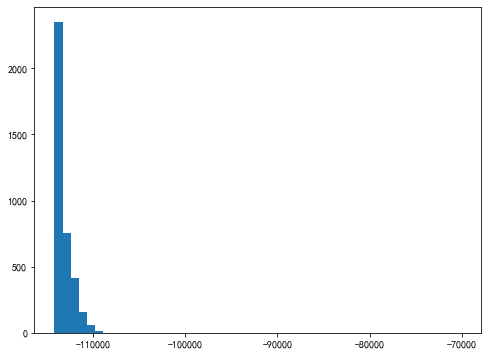

In [11]:
# plt.hist(df_Y,bins=30)  # 查看目标变量分布情况
# B40存在异常值： data["Y"] > -92000

plt.figure(figsize=(8,6))
plt.hist(df_Y,bins=50,)  # 查看目标变量分布情况
plt.xlabel = "团簇能量值"
plt.ylabel = "团簇频数"
plt.show()
# Au20 存在离群值，-1530.908363

# 删除离群点
# data_drop = data[(data["Y"] < -1535)]
# data_drop = data[(data["Y"] < -92000)]
# data_drop.shape

In [239]:
data[(data["Y"] > -92000)]

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X124,X125,X126,X127,X128,X129,X130,X131,X132,Y
58,260.348059,92.146358,74.934405,55.822554,48.383856,42.599792,38.501719,34.403665,29.290034,27.745334,...,2.155852,2.098666,7.732736,7.712355,7.313829,5.386466,6.047938,5.329318,7.268369,-90505.475321
1942,206.852453,79.726325,68.268848,57.045339,43.163937,39.980140,35.727562,32.505516,30.066527,25.894804,...,2.389966,2.716886,6.117108,5.293850,5.616236,2.959741,2.912765,2.834316,5.856625,-70185.439454


In [12]:
# plt.hist(df_Y,bins=15)  # 查看目标变量分布情况
# plt.show()
# Au20 存在离群值，-1530.908363

# 删除离群点
# data_drop = data[(data["Y"] < -1535)]
data_drop = data[(data["Y"] < -92000)]
data_drop.shape

(3749, 148)

In [13]:
# 数据标准化
zscore = preprocessing.StandardScaler()
data_scale = zscore.fit_transform(data_drop)
data_scale.shape

(3749, 148)

In [16]:
# 主成分降维
pca = PCA(n_components=0.9)
pca.fit(data_scale[:,0:data_scale.shape[1]-1])
data_scale_pca = pca.transform(data_scale[:,0:data_scale.shape[1]-1])
data_scale_pca.shape

(3749, 32)

In [17]:
# 划分数据集（测试发现：为标准化，进行降维之后效果较差）

# 下面是标准化，未进行主成分降维的数据
# X_data = data_scale[:,range(data_scale.shape[1]-1)]
# Y_data = data_scale[:,-1]

# 下面是标准化，进行主成分降维的数据
X_data = data_scale_pca[:,range(data_scale_pca.shape[1]-1)]
Y_data = data_scale[:,-1]

# 下面是不标准化，未进行主成分降维的数据
# X_data = data_drop.iloc[:,range(data_drop.shape[1]-1)]
# Y_data = data_drop.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X_data,Y_data,random_state=200,test_size=0.7)



In [19]:
def cross_valid_allmodel(model,X,Y,kfold=5):
    """
    构建一个交叉验证方法
    返回交叉验证的评分
    """
    cv = ShuffleSplit(n_splits=20, test_size=.3, random_state=0) 
    scores_CV = cross_val_score(model, X_data, Y_data, cv=cv)  
    return scores_CV

models = {
    "Linear Regression":LinearRegression(),
    "Ridge Regression":Ridge(),
    "Linear SVM":LinearSVR(),
    "SVM":SVR(),
#     "Random Forest":RandomForestRegressor(), # 计算时间较长
    "XGBoost":XGBRegressor(),
    "AdaBoost":AdaBoostRegressor()
}

scores_dict = {}
for name,model in models.items():
    scores_CV = cross_valid_allmodel(model,X_data, Y_data,kfold=10)
    print(name,":",scores_CV)
    scores_dict[name] = scores_CV  # 保存交叉验证评分结果
df_scoresCV = pd.DataFrame(scores_dict)
df_scoresCV.to_csv("../A2_data/A2_output/df_scoresCVB45.csv",index=False,header=True)

Linear Regression : [0.90674028 0.88000706 0.90126366 0.90328732 0.90872542 0.88805077
 0.89166078 0.88638758 0.9143474  0.90018208 0.88645308 0.90807561
 0.89537245 0.88978127 0.90005071 0.88070255 0.89572738 0.90858505
 0.88465269 0.90197997]
Ridge Regression : [0.90674321 0.8800009  0.901262   0.90328623 0.90872628 0.88804772
 0.89165991 0.88638667 0.91435175 0.90018699 0.88645629 0.9080787
 0.8953685  0.88978477 0.90006011 0.88070889 0.89572861 0.90858272
 0.88464196 0.90198543]
Linear SVM : [0.8951281  0.85757457 0.88012883 0.87976731 0.88343448 0.86515735
 0.87968579 0.85944814 0.8925273  0.87644088 0.86599557 0.89441878
 0.86609542 0.8783938  0.88251515 0.86657042 0.88092521 0.88483579
 0.85758596 0.89110673]
SVM : [0.93383191 0.8983324  0.93259465 0.93984623 0.93860327 0.91314655
 0.91217199 0.91135979 0.94023877 0.94067454 0.9122699  0.9363849
 0.92287416 0.91337959 0.93746195 0.90998095 0.92543427 0.94137819
 0.90358231 0.9398377 ]
XGBoost : [0.90672439 0.8894945  0.90981375 

TypeError: 'str' object is not callable

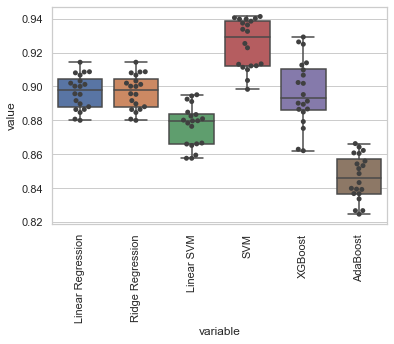

In [21]:
score_plotdata = pd.DataFrame(scores_dict).melt()

# 可视化绘制箱线图
sns.set(style="whitegrid", color_codes=True)
sns.boxplot(x="variable", y="value",data=score_plotdata)
sns.swarmplot(x="variable", y="value", data=score_plotdata, color=".25")
plt.xticks(rotation=90)
plt.xlabel("Machine Learning Models")
plt.ylabel("Score")
plt.show()

"""
从不同模型交叉验证的箱线图可以发现，黑箱算法（SVM/XGBoost/AdaBoost）普遍比白箱算法（线性回归，岭回归）预测效果较好。
但白箱算法的预测评分的中位数也在0.91附近，在应用中完全可以接受。
故考虑模型可接受性，最终预测模型选择线性回归模型
"""

[-0.097  0.004  0.082  0.116 -0.144  0.026  0.011  0.047 -0.009 -0.009
 -0.077  0.035 -0.073  0.025 -0.065  0.039 -0.125 -0.136  0.021  0.051
 -0.047  0.046  0.076 -0.116  0.033  0.133  0.072  0.024  0.007 -0.014
  0.074]
Training set score:0.9099570033
Test set score:0.8941867178
Training set MSE:0.10
Test set MSE:0.10


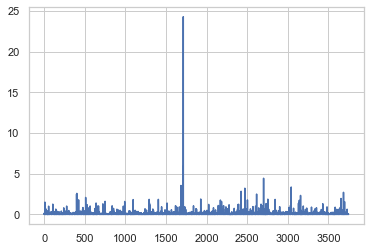

'由于数据中存在异常值，所以可以发现残差图中有一处明显凸起。但整体上而言，无异常现象。'

In [24]:
"""线性回归"""
lr = LinearRegression(fit_intercept=False,normalize=True,n_jobs=10).fit(X_train,y_train)
lr_coef = np.round(lr.coef_,3)
print(lr_coef)
print('Training set score:{:.10f}'.format(lr.score(X_train,y_train)))
print('Test set score:{:.10f}'.format(lr.score(X_test,y_test)))
print("Training set MSE:{:.2f}".format(mean_squared_error(y_train,lr.predict(X_train))))
print("Test set MSE:{:.2f}".format(mean_squared_error(y_test,lr.predict(X_test))))
lr_predict = lr.predict(X_data)
predict_data = pd.concat([pd.DataFrame(X_data),pd.DataFrame(Y_data,columns=["Y"]),pd.DataFrame(lr_predict,columns=["predict"])],axis=1)
predict_data.to_csv("../A2_data/A2_output/B45_predictdata.csv",index=False,header=True)

# 残差图
plt.plot((lr.predict(X_data)-Y_data)**2)
plt.show()
"由于数据中存在异常值，所以可以发现残差图中有一处明显凸起。但整体上而言，无异常现象。"